## Import

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install -U scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install statsmodels
# !pip install tqdm

import os
import hashlib
import collections
import datetime
from base64 import b64encode

import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import scipy
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm


## Считаем данные

In [2]:
shop_metrics_new = pd.read_csv("../data/shop_df_metrics_dec.csv").drop(columns="Unnamed: 0")
shop_metrics_old = pd.read_csv("../data/shop_df_metrics_sept.csv").drop(columns="Unnamed: 0")
shop_users_info = pd.read_csv("../data/shop_df_users.csv").drop(columns="Unnamed: 0")

In [3]:
shop_metrics_new.head()


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


In [4]:
shop_metrics_old.head()


,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


In [5]:
shop_users_info.head()


,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


In [6]:
def salt_generator(salt=None):
    """Генератор соли"""
    salt = os.urandom(8)
    return b64encode(salt).decode("ascii")


def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df["hash"] = ((df["user_id"].astype(str)) + "#" + salt).apply(
        lambda x: hashlib.sha256(x.encode("utf-8")).hexdigest()
    )
    df["group"] = (df["hash"].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: "A" if x == 0 else "B")

    return df[["user_id", "group"]].drop_duplicates()

## 1. T-test и U-test Манна-Уитни на cart_added_cnt

<Axes: xlabel='cart_added_cnt', ylabel='Density'>

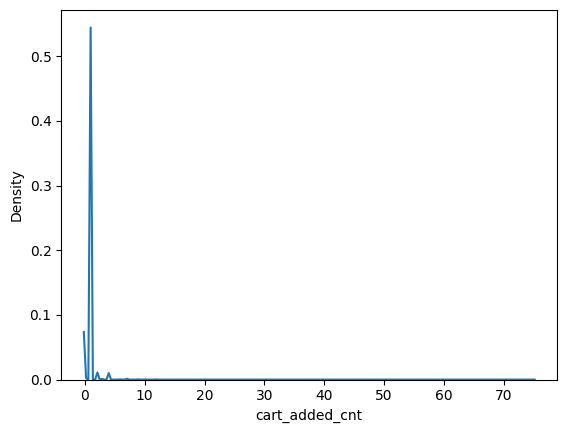

In [17]:
sns.kdeplot(shop_metrics_new["cart_added_cnt"])


<Axes: xlabel='cart_added_cnt', ylabel='Density'>

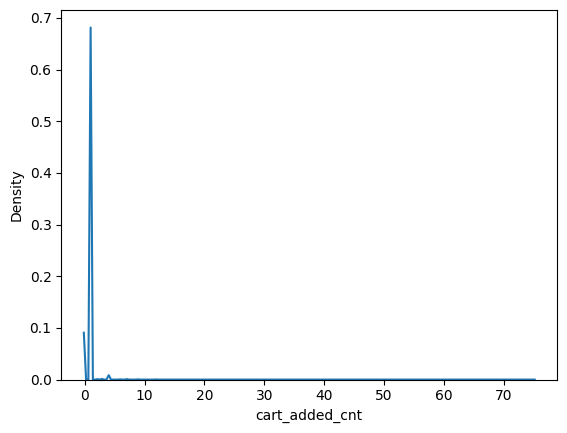

In [18]:
sns.kdeplot(shop_metrics_old["cart_added_cnt"])


## 1.1 TTEST

In [7]:
shop = shop_metrics_new.drop(columns=["group"])
TARGET_METRIC = "cart_added_cnt"

correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=["user_id"]).drop_duplicates()

    vec_a = new_df[(new_df["group"] == "A")][TARGET_METRIC]
    vec_b = new_df[(new_df["group"] == "B")][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}%, correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 1000/1000 [10:30<00:00,  1.58it/s]

0.02257390473412044
 power: 65.2%, correctness: 94.5%


## 1.2 MANNWHITNEYU

In [8]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=["user_id"]).drop_duplicates()

    vec_a = new_df[(new_df["group"] == "A")][TARGET_METRIC]
    vec_b = new_df[(new_df["group"] == "B")][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.mannwhitneyu(vec_a, vec_b)[1], stats.mannwhitneyu(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}%, correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 1000/1000 [14:42<00:00,  1.13it/s]

0.0663721553955001
 power: 99.6%, correctness: 94.69999999999999%


## 2. CUPED

In [9]:
def cuped_transform(df, metrics):
    new_columns = [str(m + "_cuped") for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m + "_covariate")
        cuped_column = str(m + "_cuped")
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column])) / (df_mini.loc[:, covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


In [10]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[["user_id", TARGET_METRIC]], on=["user_id"], how="left")
shop_metrics_all = shop_metrics_all.rename(
    columns={f"{TARGET_METRIC}_x": TARGET_METRIC, f"{TARGET_METRIC}_y": f"{TARGET_METRIC}_covariate"}
)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC])


## 2.1.1 Cuped stats

In [11]:
print(
    f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].mean()}'
)

метрика_cuped A: 0.136382315726573,         метрика_cuped B: 0.1372102898471418


In [12]:
print(
    f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC].mean()}'
)

метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [13]:
print(
    f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC}_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC}_cuped"].var()}'
)

метрика_cuped A: 0.01823518359964534,         метрика_cuped B: 0.02149536345539653


In [14]:
print(
    f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC].var()}'
)

метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569


## 2.1.2 Cuped A/B

In [15]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=["user_id"]).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[["user_id", TARGET_METRIC]], on=["user_id"], how="left")
    all_df = all_df.rename(
        columns={f"{TARGET_METRIC}_x": TARGET_METRIC, f"{TARGET_METRIC}_y": f"{TARGET_METRIC}_covariate"}
    )

    cuped_df = cuped_transform(all_df, [TARGET_METRIC])

    vec_a = cuped_df[(cuped_df["group"] == "A")][f"{TARGET_METRIC}_cuped"]
    vec_b = cuped_df[(cuped_df["group"] == "B")][f"{TARGET_METRIC}_cuped"]
    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)

print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]

 power: 100.0% , correctness: 97.0%


## 2.2.1 Cuped ln

In [17]:
TARGET_METRIC_LN = TARGET_METRIC + "_ln"
shop_metrics_new[TARGET_METRIC_LN] = np.log(shop_metrics_new[TARGET_METRIC] + 1)
shop_metrics_old[TARGET_METRIC_LN] = np.log(shop_metrics_old[TARGET_METRIC] + 1)
shop[TARGET_METRIC_LN] = np.log(shop[TARGET_METRIC] + 1)


In [18]:
shop_metrics_all = pd.merge(
    shop_metrics_new, shop_metrics_old[["user_id", TARGET_METRIC_LN]], on=["user_id"], how="left"
)
shop_metrics_all = shop_metrics_all.rename(
    columns={f"{TARGET_METRIC_LN}_x": TARGET_METRIC_LN, f"{TARGET_METRIC_LN}_y": f"{TARGET_METRIC_LN}_covariate"}
)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC_LN])

## 2.2.2 Cuped ln stats

In [19]:
print(
    f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC_LN}_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC_LN}_cuped"].mean()}'
)
print(
    f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC_LN].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC_LN].mean()}'
)

метрика_cuped A: 0.08034157852348373,         метрика_cuped B: 0.08072086382541538
метрика без cuped A: 0.07974289062640032,         метрика без cuped B: 0.08132020317245879


In [20]:
print(
    f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][f"{TARGET_METRIC_LN}_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][f"{TARGET_METRIC_LN}_cuped"].var()}'
)
print(
    f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"][TARGET_METRIC_LN].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"][TARGET_METRIC_LN].var()}'
)

метрика_cuped A: 0.002055014378642915,         метрика_cuped B: 0.0017558187333519104
метрика без cuped A: 0.06466232955752058,         метрика без cuped B: 0.06628259108478471


## 2.2.3 Cuped ln A/B

In [23]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=["user_id"]).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[["user_id", TARGET_METRIC_LN]], on=["user_id"], how="left")
    all_df = all_df.rename(
        columns={f"{TARGET_METRIC_LN}_x": TARGET_METRIC_LN, f"{TARGET_METRIC_LN}_y": f"{TARGET_METRIC_LN}_covariate"}
    )

    cuped_df = cuped_transform(all_df, [TARGET_METRIC_LN])

    vec_a = cuped_df[(cuped_df["group"] == "A")][f"{TARGET_METRIC_LN}_cuped"]
    vec_b = cuped_df[(cuped_df["group"] == "B")][f"{TARGET_METRIC_LN}_cuped"]
    vec_b_effect = vec_b * 1.05

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)

print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]

 power: 100.0% , correctness: 91.0%


## 2.3.1 Cuped rank transform

In [24]:
def rank(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis=0)
    df["rank"] = df[metric].rank()

    return df

In [25]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[["user_id", TARGET_METRIC]], on=["user_id"], how="left")
shop_metrics_all = shop_metrics_all.rename(
    columns={f"{TARGET_METRIC}_x": TARGET_METRIC, f"{TARGET_METRIC}_y": f"{TARGET_METRIC}_covariate"}
)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), [TARGET_METRIC])

ranked_df = rank(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"],
    f"{TARGET_METRIC}_cuped",
)

## 2.3.2 Cuped rank stats

In [26]:
print(
    f'метрика_cuped A: {ranked_df[ranked_df.group == "A"][f"rank"].mean()}, \
        метрика_cuped B: {ranked_df[ranked_df.group == "B"][f"rank"].mean()}'
)
print(
    f'метрика без cuped A: {ranked_df[ranked_df.group == "A"][TARGET_METRIC].mean()}, \
        метрика без cuped B: {ranked_df[ranked_df.group == "B"][TARGET_METRIC].mean()}'
)

метрика_cuped A: 111157.3299691882,         метрика_cuped B: 111364.78283723022
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [27]:
print(
    f'метрика_rank_cuped A: {ranked_df[ranked_df.group == "A"][f"rank"].var()}, \
        метрика_rank_cuped B: {ranked_df[ranked_df.group == "B"][f"rank"].var()}'
)
print(
    f'метрика без cuped A: {ranked_df[ranked_df.group == "A"][TARGET_METRIC].var()}, \
        метрика без cuped B: {ranked_df[ranked_df.group == "B"][TARGET_METRIC].var()}'
)

метрика_rank_cuped A: 1138307738.193268,         метрика_rank_cuped B: 1151768826.5589178
метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569


## 2.3.3 Cuped rank A/B

In [28]:
correctness = []
power = []

for i in tqdm(range(100)):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=["user_id"]).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[["user_id", TARGET_METRIC]], on=["user_id"], how="left")
    all_df = all_df.rename(
        columns={f"{TARGET_METRIC}_x": TARGET_METRIC, f"{TARGET_METRIC}_y": f"{TARGET_METRIC}_covariate"}
    )

    cuped_df = cuped_transform(all_df, [TARGET_METRIC])

    ranked_df = rank(
        cuped_df[cuped_df.group == "A"], cuped_df[cuped_df.group == "B"], f"{TARGET_METRIC}_cuped"
    )

    vec_a = ranked_df[(ranked_df["group"] == "A")]["rank"]
    vec_b = ranked_df[(ranked_df["group"] == "B")]["rank"]

    vec_b_effect = cuped_df[cuped_df["group"] == "B"][f"{TARGET_METRIC}_cuped"] * 1.05
    new_df_b = cuped_df[cuped_df.group == "B"].drop(columns=[f"{TARGET_METRIC}_cuped"])
    new_df_b[f"{TARGET_METRIC}_cuped"] = list(vec_b_effect)

    ranked_df_effect = rank(cuped_df[cuped_df.group == "A"], new_df_b, f"{TARGET_METRIC}_cuped")
    vec_a_power = ranked_df_effect[(ranked_df_effect["group"] == "A")]["rank"]
    vec_b_power = ranked_df_effect[(ranked_df_effect["group"] == "B")]["rank"]

    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 100/100 [01:39<00:00,  1.01it/s]

 power: 100.0% , correctness: 94.0%


# 3. Buckets split

## 3.1 Lognorm destrib

In [43]:
np.random.seed(42)
s = 0.55
x = np.linspace(scipy.stats.lognorm.ppf(0.01, s), scipy.stats.lognorm.ppf(0.99, s), 10000)

data = stats.lognorm.pdf(x, s)
data = np.random.permutation(data)

df_lognormal = pd.DataFrame({"target": data})
df_lognormal["user_id"] = df_lognormal.index
df_lognormal["bucket_num"] = df_lognormal["user_id"] % 1000
df_lognormal.head()

,target,user_id,bucket_num
0,0.092058,0,0
1,0.216087,1,1
2,0.815848,2,2
3,0.209380,3,3
4,0.236065,4,4


## Buckets A/B

In [44]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(df_lognormal.copy(), user_salt=salt_generator())
    new_df = pd.merge(df_lognormal, new_group, how="left", on=["user_id"]).drop_duplicates()

    vec_a = new_df[(new_df["group"] == "A")]["target"]
    vec_b = new_df[(new_df["group"] == "B")]["target"]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 1000/1000 [00:34<00:00, 28.90it/s]

0.07419441297532722
 power: 52.0% , correctness: 94.39999999999999%


In [45]:
df_ln_bucket = df_lognormal.groupby("bucket_num")["target"].mean().to_frame().reset_index(drop=False)
df_ln_bucket["user_id"] = df_ln_bucket["bucket_num"]
df_ln_bucket.head()

,bucket_num,target,user_id
0,0,0.172720,0
1,1,0.391670,1
2,2,0.412363,2
3,3,0.452876,3
4,4,0.264277,4


In [46]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(df_ln_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(df_ln_bucket, new_group, how="left", on=["user_id"]).drop_duplicates()

    vec_a = new_df[(new_df["group"] == "A")]["target"]
    vec_b = new_df[(new_df["group"] == "B")]["target"]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 1000/1000 [00:09<00:00, 103.28it/s]

-0.08902439621267362
 power: 17.7% , correctness: 93.9%


## 3.2 Buckets real

In [48]:
shop_bucket = shop.copy()
shop_bucket["bucket_num"] = shop_bucket.index % 1000

shop_bucket = shop_bucket.groupby("bucket_num")[TARGET_METRIC].mean().to_frame().reset_index(drop=False)
shop_bucket["user_id"] = shop_bucket["bucket_num"]

shop_bucket.head()

,bucket_num,cart_added_cnt,user_id
0,0,0.076233,0
1,1,0.143498,1
2,2,0.134529,2
3,3,0.062780,3
4,4,0.094170,4


### 3.2.1 Buckets + lognorm

In [50]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(shop_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop_bucket, new_group, how="left", on=["user_id"]).drop_duplicates()

    vec_a = new_df[(new_df["group"] == "A")][TARGET_METRIC]
    vec_b = new_df[(new_df["group"] == "B")][TARGET_METRIC]
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 1000/1000 [00:09<00:00, 107.22it/s]

0.26162350629930764
 power: 8.799999999999999% , correctness: 94.69999999999999%


### 3.2.2 Buckets default

In [51]:
correctness = []
power = []

for i in tqdm(range(1000)):
    new_group = groups_splitter(shop_bucket.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop_bucket, new_group, how="left", on=["user_id"]).drop_duplicates()

    vec_a = new_df[(new_df["group"] == "A")][TARGET_METRIC]
    vec_b = new_df[(new_df["group"] == "B")][TARGET_METRIC]
    vec_b_effect = vec_b + vec_b.mean() * 0.05
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean()) / vec_a.mean())
print(
    f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%"
)

100%|██████████| 1000/1000 [00:09<00:00, 110.02it/s]

0.03231432700593058
 power: 68.8% , correctness: 93.9%


## 4. PostStratification

In [52]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=["user_id"], how="left")
shop_w_features.drop(
    ["is_viewed", "is_viewed", "products_viewed_cnt", "price_sum", "is_cart_added", "is_purchased", "purchased_cnt"],
    axis=1,
    inplace=True,
)
shop_w_features.head()

,user_id,group,cart_added_cnt,cart_added_cnt_ln,user_age,user_sex
0,1515915625353226922,B,0,0.0,55,f
1,1515915625353230067,A,0,0.0,58,m
2,1515915625353230683,A,0,0.0,23,f
3,1515915625353230922,A,0,0.0,33,m
4,1515915625353234047,A,0,0.0,26,f


In [53]:
def map_age(age: int):
    if age in range(18, 25):
        return "18-24"
    elif age in range(25, 46):
        return "25-45"
    elif age in range(46, 61):
        return "45-60"
    elif age in range(61, 76):
        return "61-75"
    else:
        return "76+"


shop_w_features["age_group"] = shop_w_features["user_age"].apply(map_age)
shop_w_features["sex_age_group"] = shop_w_features["user_sex"] + "_" + shop_w_features["age_group"]
shop_w_features.head()

,user_id,group,cart_added_cnt,cart_added_cnt_ln,user_age,user_sex,age_group,sex_age_group
0,1515915625353226922,B,0,0.0,55,f,45-60,f_45-60
1,1515915625353230067,A,0,0.0,58,m,45-60,m_45-60
2,1515915625353230683,A,0,0.0,23,f,18-24,f_18-24
3,1515915625353230922,A,0,0.0,33,m,25-45,m_25-45
4,1515915625353234047,A,0,0.0,26,f,25-45,f_25-45


### 4.1 Stats

### 4.1.1 Befoure

#### Ttest

In [56]:
stats.ttest_ind(
    shop_w_features[shop_w_features.group == "A"][TARGET_METRIC],
    shop_w_features[shop_w_features.group == "B"][TARGET_METRIC],
)

TtestResult(statistic=-0.7331870372707812, pvalue=0.4634447828246868, df=406861.0)

#### Means

In [57]:
(
    shop_w_features[shop_w_features.group == "B"][TARGET_METRIC].mean()
    - shop_w_features[shop_w_features.group == "A"][TARGET_METRIC].mean()
) / shop_w_features[shop_w_features.group == "A"][TARGET_METRIC].mean() * 100

1.1242734540045785

#### Std

In [83]:
print(
    shop_w_features[shop_w_features.group == "A"][TARGET_METRIC].std(),
    shop_w_features[shop_w_features.group == "B"][TARGET_METRIC].std(),
)

0.576689119780438 0.5987645651973791


### 4.2 Stratification

In [59]:
N = shop_w_features["user_id"].nunique()

strats_weights = {}
for i in range(shop_w_features["sex_age_group"].nunique()):
    key = shop_w_features["sex_age_group"].value_counts().index[i]
    strats_weights[key] = shop_w_features["sex_age_group"].value_counts().iloc[i] / N

strats_weights

{'m_25-45': 0.18906118275684936,
 'm_45-60': 0.1342073376050415,
 'm_61-75': 0.13333726586099007,
 'f_25-45': 0.12529770463276335,
 'f_45-60': 0.08958052219051622,
 'f_61-75': 0.08893657078672673,
 'm_76+': 0.08015228713350686,
 'm_18-24': 0.06318097246493291,
 'f_76+': 0.05458102604562224,
 'f_18-24': 0.04166513052305076}

In [60]:
mean_a = 0
mean_b = 0

std_a = 0
std_b = 0

for sex_age in strats_weights:
    mean_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].mean() * strats_weights[sex_age]
    mean_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].mean() * strats_weights[sex_age]

    std_a += shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].std()**2 * strats_weights[sex_age]
    std_b += shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['sex_age_group'] == sex_age)][TARGET_METRIC].std()**2 * strats_weights[sex_age]

std_a, std_b = std_a / N, std_b / N

n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

print(f'effect: {(mean_b - mean_a) / mean_a * 100}, std_a: {std_a}, std_b: {std_b}')

stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

effect: 1.1238909894351434, std_a: 8.179175411681481e-07, std_b: 8.814427810322829e-07


Ttest_indResult(statistic=-506738.4365829322, pvalue=0.0)

## 4.3 Stratification A/B

In [61]:
shop_new = shop_w_features.drop("group", axis=1)

In [63]:
corr_group = 0
power_group = 0

for sex_age in tqdm(strats_weights):
    correctness = []
    power = []
    for _ in range(100):
        new_group = groups_splitter(shop_new.copy(), user_salt=salt_generator())
        new_df = pd.merge(shop_new, new_group, how="left", on=["user_id"]).drop_duplicates()

        vec_a = new_df[(new_df.group == "A") & (new_df["sex_age_group"] == sex_age)][TARGET_METRIC]
        vec_b = new_df[(new_df.group == "B") & (new_df["sex_age_group"] == sex_age)][TARGET_METRIC]
        vec_b_effect = vec_b + vec_b.mean() * 0.05

        p_cor_group, p_power_group = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]

        correctness.append(p_cor_group)
        power.append(p_power_group)

    correctness = np.array(correctness)
    power = np.array(power)

    power_group += (power[power < 0.05].shape[0] / power.shape[0]) * strats_weights[sex_age]
    corr_group += (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * strats_weights[sex_age]

print(f" power: {power_group * 100}% , correctness: {corr_group * 100}%")

100%|██████████| 10/10 [22:34<00:00, 135.45s/it]

 power: 20.718182778969826% , correctness: 95.56951111307738%
